# Step-by-Step Explanation and Code

## 1. Data Loading and Initial Checks
Load the dataset and inspect for duplicates

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_excel('AnomaData.xlsx')

In [3]:
# View the top 5 rows
print(df.head())

# View dataset structure
print(df.info())


                 time  y        x1        x2        x3         x4        x5  \
0 1999-05-01 00:00:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1 1999-05-01 00:02:00  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2 1999-05-01 00:04:00  0  0.363848 -4.681394 -4.353147  14.127997 -0.138636   
3 1999-05-01 00:06:00  0  0.301590 -4.758934 -4.023612  13.161566 -0.148142   
4 1999-05-01 00:08:00  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x51        x52       x54  \
0 -20.669883  0.000732 -0.061114  ...  29.984624  10.091721 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  29.984624  10.095871 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  29.984624  10.100265 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  29.984624  10.104660 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  29.984624  10.109054 -4.939414   

         x55        x56       x57       x58       x59       x60  y.1  
0 -24.590146  1

In [4]:
# Check for duplicate columns
duplicate_columns = df.columns[df.columns.duplicated()]
if duplicate_columns.any():
    df = df.loc[:, ~df.columns.duplicated()]

# Verify the columns
print(df.columns)

Index(['time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60',
       'y.1'],
      dtype='object')


## 2. Convert Time Column to Datetime

Parse the 'time' column correctly.

In [5]:
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%y %H:%M', errors='coerce')
# If the above format doesn't work, try switching day and month
if df['time'].isnull().any():
    df['time'] = pd.to_datetime(df['time'], format='%m-%d-%y %H:%M')

## 3. Exploratory Data Analysis (EDA)

Check data distribution, missing values, and target balance.

time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64


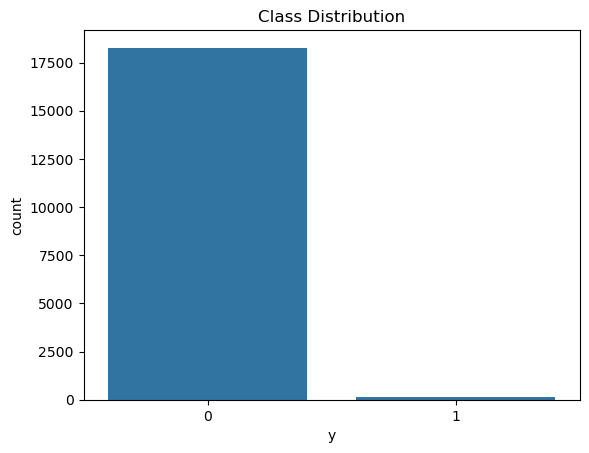

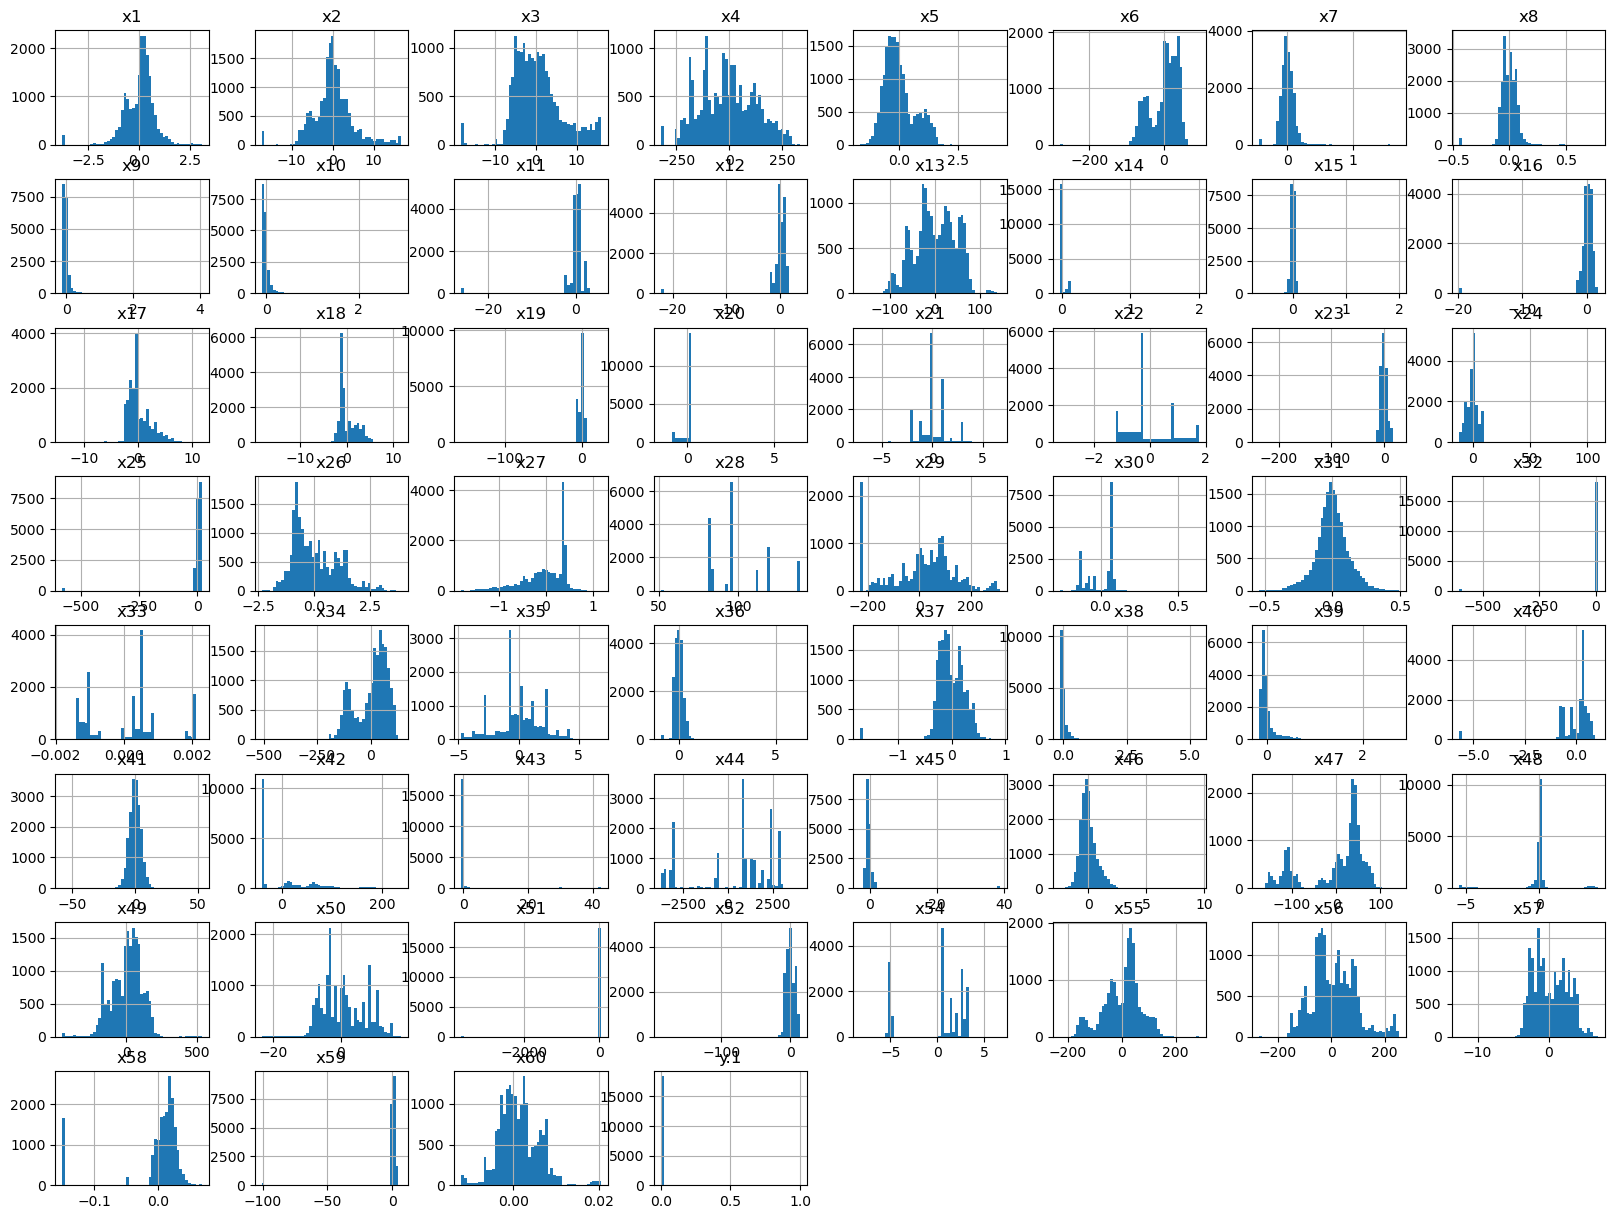

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values
print(df.isnull().sum())

# Target distribution
sns.countplot(x='y', data=df)
plt.title('Class Distribution')
plt.show()

# Plot feature distributions
df.drop(columns=['time', 'y']).hist(bins=50, figsize=(20,15))
plt.show()

## 4. Feature Engineering

Extract time-based features and handle scaling.

In [7]:
# Extract hour and minute
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

# Drop the original time column
df.drop('time', axis=1, inplace=True)

# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df.drop('y', axis=1)
y = df['y']

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

## 5. Train-Test Split with Temporal Validation

Split data chronologically to preserve time-series order.

In [8]:
split_idx = int(0.8 * len(df))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## 6. Model Training and Hyperparameter Tuning

Use XGBoost with cross-validation for tuning.

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

model = XGBClassifier()
params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(model, params, cv=3, scoring='f1')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


## 7. Model Evaluation

Assess performance using multiple metrics.

In [10]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred = best_model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3646
           1       0.04      0.03      0.04        34

    accuracy                           0.99      3680
   macro avg       0.52      0.51      0.51      3680
weighted avg       0.98      0.99      0.98      3680

F1 Score: 0.03508771929824561
Accuracy: 0.9850543478260869


In [11]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 8. Deployment Plan

Save the model and scaler for deployment.

In [12]:
import joblib

joblib.dump(best_model, 'anomaly_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Example API using Flask
from flask import Flask, request, jsonify

app = Flask(__name__)
model = joblib.load('anomaly_model.pkl')
scaler = joblib.load('scaler.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    data_scaled = scaler.transform([data])
    prediction = model.predict(data_scaled)
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1